In [ ]:
import pandas as pd

In [ ]:
categorical = set((
    'Asal',
    'Alamat Tinggal'
))
df = pd.read_excel("DATABASE LENGKAP SI 2016.xlsx")
# df = pd.read_csv("DATABASE LENGKAP SI 2016.csv", sep=";")

In [ ]:
def get_year(date):
    return str(date)[0:4]
df

,NRP,Sex,DOB,Dom_email,Asal,Alamat Tinggal,Phone_Number
0,5216100001,Perempuan,1998-04-24 00:00:00,0,Sidoarjo,Manyar,858
1,5216100002,Perempuan,1998-04-10 00:00:00,0,Mojokerto,Gebang,857
2,5216100003,Laki-Laki,1998-07-16 00:00:00,0,Serang,Gaada mas,823
3,5216100005,Laki-Laki,1997-09-02 00:00:00,2,Magetan,Asrama,813
4,5216100006,Perempuan,1997-06-14 00:00:00,0,Lumajang,Gebang,857
...,...,...,...,...,...,...,...
140,5216100160,Perempuan,2016-02-24 00:00:00,3,Gresik,Keputih,857
141,5216100162,Perempuan,2000-01-13 00:00:00,0,Jakarta,Wisma Permai,812
142,5216100701,Laki-Laki,1997-07-31 00:00:00,0,Blitar,Asrama,857
143,5216100702,Perempuan,1997-10-12 00:00:00,0,Tapin,Asrama,857


In [ ]:
df['DOB'] = df['DOB'].apply(get_year)

In [ ]:
df["Sex"].replace({"Laki-Laki": 0, "Perempuan": 1}, inplace=True)
# df["Asal"].replace({"Sidoarjo": 1, "Mojokerto": 2, "Serang": 3, "Magetan":4, "Lumajang":5, "Gresik":6, "Jakarta":7, "Blitar": 8, "Tapin" : 9, "Cot Tunong":10, "Surabaya":11, "Pasuruan":12, "Jombang":13, "Bandung":14, "Situbondo":15, "Ngawi":16, "Kediri":17, "Cilacap":18, "Madiun":19, "padang":20, "Tulungagung": 21, "Padang": 22, "Semarang":23, "Bogor":24, "Malang":25, "Sampang":26, "Palembang":27, "Batusangkar":28, "Ujung Pandang":29, "Manokwari":30, "Mataram":31, "Muntok":32, "Batam":33, "Singkawang":34, "Cilegon":35, "Jombang":36, "Bojonegoro":37, "Banyuwangi":38, "Ponorogo":39, "Jember":40, "Bukittinggi":41, "Bontang":42, "Denpasar":43, "Kupang":44, "Cianjur":45, "Medan":46, "Samarinda":47, "Tangerang":48, "Palu":49,   }, inplace=True)

In [ ]:
df

,NRP,Sex,DOB,Dom_email,Asal,Alamat Tinggal,Phone_Number
0,5216100001,1,1998,0,Sidoarjo,Manyar,858
1,5216100002,1,1998,0,Mojokerto,Gebang,857
2,5216100003,0,1998,0,Serang,Gaada mas,823
3,5216100005,0,1997,2,Magetan,Asrama,813
4,5216100006,1,1997,0,Lumajang,Gebang,857
...,...,...,...,...,...,...,...
140,5216100160,1,2016,3,Gresik,Keputih,857
141,5216100162,1,2000,0,Jakarta,Wisma Permai,812
142,5216100701,0,1997,0,Blitar,Asrama,857
143,5216100702,1,1997,0,Tapin,Asrama,857


In [ ]:
df['DOB'] = df['DOB'].str.replace(',','').astype(int)


In [ ]:
# df['Phone_Number'] = df['Phone_Number'].str.replace(',','').astype(int)

In [ ]:
df.to_excel('test.xlsx')

In [ ]:
for name in categorical:
    df[name] = df[name].astype('category')

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145 entries, 0 to 144
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   NRP             145 non-null    int64   
 1   Sex             145 non-null    int64   
 2   DOB             145 non-null    int64   
 3   Dom_email       145 non-null    int64   
 4   Asal            145 non-null    category
 5   Alamat Tinggal  145 non-null    category
 6   Phone_Number    145 non-null    int64   
dtypes: category(2), int64(5)
memory usage: 10.6 KB


In [ ]:
def get_spans(df, partition, scale=None):
    spans = {}
    for column in df.columns:
        if column in categorical:
            span = len(df[column][partition].unique())
        else:
            span = df[column][partition].max()-df[column][partition].min()
        if scale is not None:
            span = span/scale[column]
        spans[column] = span
    return spans

In [ ]:
full_spans = get_spans(df, df.index)
full_spans

{'Alamat Tinggal': 50,
 'Asal': 47,
 'DOB': 5203,
 'Dom_email': 9,
 'NRP': 702,
 'Phone_Number': 815,
 'Sex': 1}

In [ ]:
def split(df, partition, column):
    """
    :param        df: The dataframe to split
    :param partition: The partition to split
    :param    column: The column along which to split
    :        returns: A tuple containing a split of the original partition
    """
    dfp = df[column][partition]
    if column in categorical:
        values = dfp.unique()
        lv = set(values[:len(values)//2])
        rv = set(values[len(values)//2:])
        return dfp.index[dfp.isin(lv)], dfp.index[dfp.isin(rv)]
    else:        
        median = dfp.median()
        dfl = dfp.index[dfp < median]
        dfr = dfp.index[dfp >= median]
        return (dfl, dfr)

In [ ]:
def is_k_anonymous(df, partition, sensitive_column, k=3):
    """
    :param               df: The dataframe on which to check the partition.
    :param        partition: The partition of the dataframe to check.
    :param sensitive_column: The name of the sensitive column
    :param                k: The desired k
    :returns               : True if the partition is valid according to our k-anonymity criteria, False otherwise.
    """
    if len(partition) < k:
        return False
    return True

def partition_dataset(df, feature_columns, sensitive_column, scale, is_valid):
    """
    :param               df: The dataframe to be partitioned.
    :param  feature_columns: A list of column names along which to partition the dataset.
    :param sensitive_column: The name of the sensitive column (to be passed on to the `is_valid` function)
    :param            scale: The column spans as generated before.
    :param         is_valid: A function that takes a dataframe and a partition and returns True if the partition is valid.
    :returns               : A list of valid partitions that cover the entire dataframe.
    """
    finished_partitions = []
    partitions = [df.index]
    while partitions:
        partition = partitions.pop(0)
        spans = get_spans(df[feature_columns], partition, scale)
        for column, span in sorted(spans.items(), key=lambda x:-x[1]):
            lp, rp = split(df, partition, column)
            if not is_valid(df, lp, sensitive_column) or not is_valid(df, rp, sensitive_column):
                continue
            partitions.extend((lp, rp))
            break
        else:
            finished_partitions.append(partition)
    return finished_partitions


In [ ]:
# pip install matplotlib
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145 entries, 0 to 144
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   NRP             145 non-null    int64   
 1   Sex             145 non-null    int64   
 2   DOB             145 non-null    int64   
 3   Dom_email       145 non-null    int64   
 4   Asal            145 non-null    category
 5   Alamat Tinggal  145 non-null    category
 6   Phone_Number    145 non-null    int64   
dtypes: category(2), int64(5)
memory usage: 10.6 KB


In [ ]:
# dfn.to_excel('test.xlsx')

In [ ]:
feature_columns = ['Dom_email', 'Phone_Number']
sensitive_column = 'Asal'
finished_partitions = partition_dataset(df, feature_columns, sensitive_column, full_spans, is_k_anonymous)

In [ ]:
# dfn.to_excel('test.xlsx')

In [ ]:
len(finished_partitions)

12

In [ ]:
import matplotlib.pylab as pl
import matplotlib.patches as patches

In [ ]:
def build_indexes(df):
    indexes = {}
    for column in categorical:
        values = sorted(df[column].unique())
        indexes[column] = { x : y for x, y in zip(values, range(len(values)))}
    return indexes

def get_coords(df, column, partition, indexes, offset=0.1):
    if column in categorical:
        sv = df[column][partition].sort_values()
        l, r = indexes[column][sv[sv.index[0]]], indexes[column][sv[sv.index[-1]]]+1.0
    else:
        sv = df[column][partition].sort_values()
        next_value = sv[sv.index[-1]]
        larger_values = df[df[column] > next_value][column]
        if len(larger_values) > 0:
            next_value = larger_values.min()
        l = sv[sv.index[0]]
        r = next_value
    # we add some offset to make the partitions more easily visible
    l -= offset
    r += offset
    return l, r

def get_partition_rects(df, partitions, column_x, column_y, indexes, offsets=[0.1, 0.1]):
    rects = []
    for partition in partitions:
        xl, xr = get_coords(df, column_x, partition, indexes, offset=offsets[0])
        yl, yr = get_coords(df, column_y, partition, indexes, offset=offsets[1])
        rects.append(((xl, yl),(xr, yr)))
    return rects

def get_bounds(df, column, indexes, offset=1.0):
    if column in categorical:
        return 0-offset, len(indexes[column])+offset
    return df[column].min()-offset, df[column].max()+offset

In [ ]:
# we calculate the bounding rects of all partitions that we created
indexes = build_indexes(df)
column_x, column_y = feature_columns[:2]
rects = get_partition_rects(df, finished_partitions, column_x, column_y, indexes, offsets=[0.0, 0.0])

In [ ]:
rects[:10]

[((0.0, 813.0), (9.0, 822.0)),
 ((0.0, 81.0), (7.0, 812.0)),
 ((0.0, 812.0), (9.0, 813.0)),
 ((0.0, 822.0), (9.0, 823.0)),
 ((0.0, 823.0), (1.0, 838.0)),
 ((0.0, 838.0), (8.0, 856.0)),
 ((0.0, 856.0), (4.0, 857.0)),
 ((0.0, 857.0), (9.0, 858.0)),
 ((0.0, 858.0), (1.0, 878.0)),
 ((0.0, 878.0), (4.0, 895.0))]

In [ ]:
df

,NRP,Sex,DOB,Dom_email,Asal,Alamat Tinggal,Phone_Number
0,5216100001,1,1998,0,Sidoarjo,Manyar,858
1,5216100002,1,1998,0,Mojokerto,Gebang,857
2,5216100003,0,1998,0,Serang,Gaada mas,823
3,5216100005,0,1997,2,Magetan,Asrama,813
4,5216100006,1,1997,0,Lumajang,Gebang,857
...,...,...,...,...,...,...,...
140,5216100160,1,2016,3,Gresik,Keputih,857
141,5216100162,1,2000,0,Jakarta,Wisma Permai,812
142,5216100701,0,1997,0,Blitar,Asrama,857
143,5216100702,1,1997,0,Tapin,Asrama,857


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145 entries, 0 to 144
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   NRP             145 non-null    int64   
 1   Sex             145 non-null    int64   
 2   DOB             145 non-null    int64   
 3   Dom_email       145 non-null    int64   
 4   Asal            145 non-null    category
 5   Alamat Tinggal  145 non-null    category
 6   Phone_Number    145 non-null    int64   
dtypes: category(2), int64(5)
memory usage: 10.6 KB


In [ ]:
# we plot the rects
def plot_rects(df, ax, rects, column_x, column_y, edgecolor='black', facecolor='none'):
    for (xl, yl),(xr, yr) in rects:
        ax.add_patch(patches.Rectangle((xl,yl),xr-xl,yr-yl,linewidth=1,edgecolor=edgecolor,facecolor=facecolor, alpha=0.5))
    ax.set_xlim(*get_bounds(df, column_x, indexes))
    ax.set_ylim(*get_bounds(df, column_y, indexes))
    ax.set_xlabel(column_x)
    ax.set_ylabel(column_y)

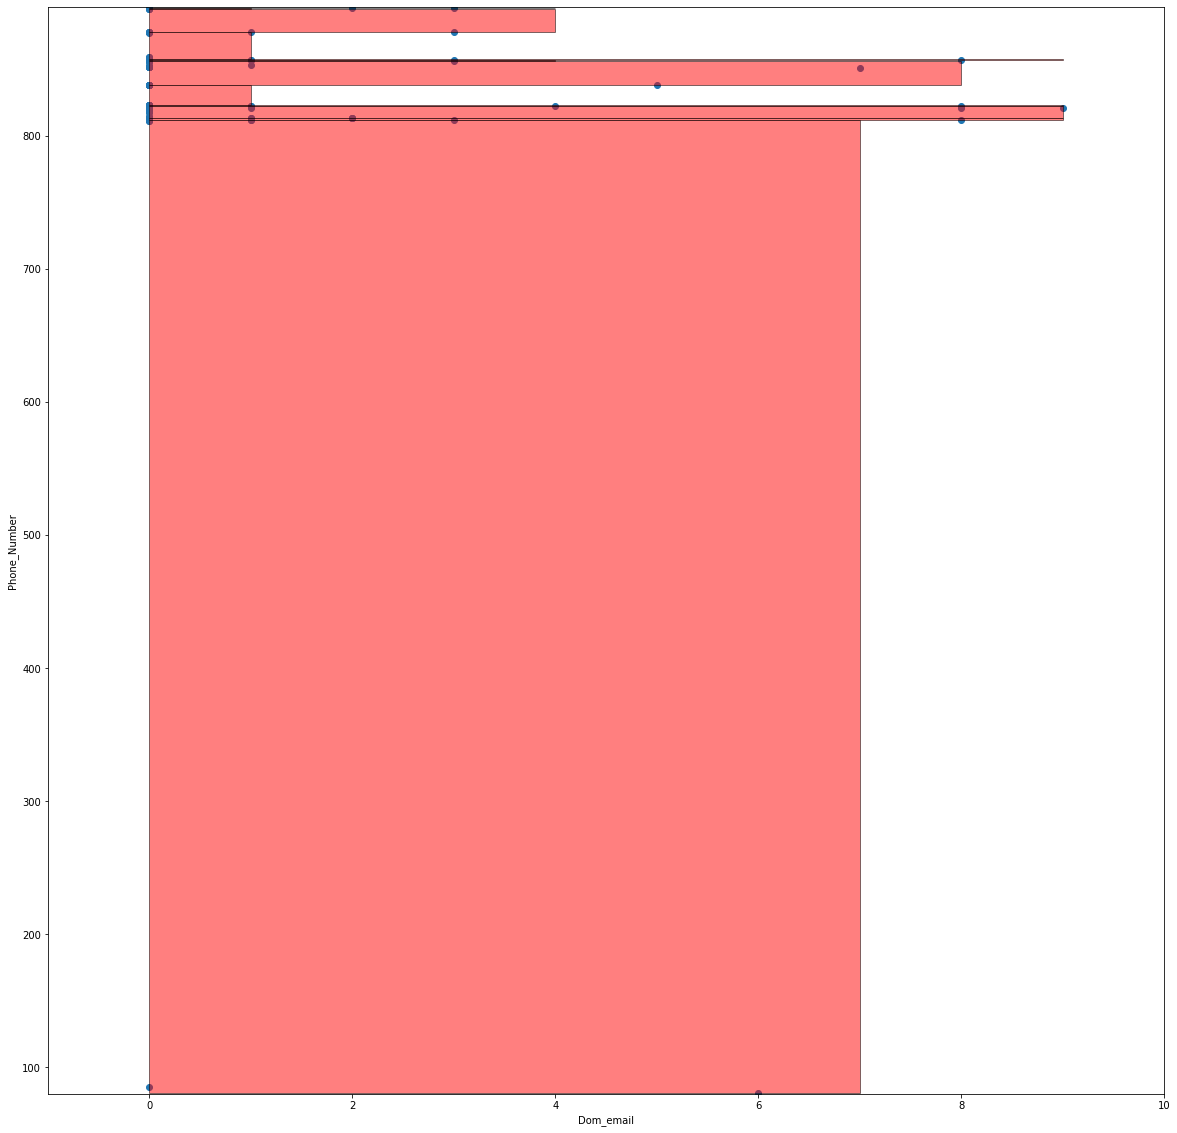

In [ ]:
pl.figure(figsize=(20,20))
ax = pl.subplot(111)
plot_rects(df, ax, rects, column_x, column_y, facecolor='r')
pl.scatter(df[column_x], df[column_y])
pl.show()

In [ ]:
def agg_categorical_column(series):
    return [','.join(set(series))]

def agg_numerical_column(series):
    return [series.mean()]

In [ ]:
def build_anonymized_dataset(df, partitions, feature_columns, sensitive_column, max_partitions=None):
    aggregations = {}
    for column in feature_columns:
        if column in categorical:
            aggregations[column] = agg_categorical_column
        else:
            aggregations[column] = agg_numerical_column
    rows = []
    for i, partition in enumerate(partitions):
        if i % 100 == 1:
            print("Finished {} partitions...".format(i))
        if max_partitions is not None and i > max_partitions:
            break
        grouped_columns = df.loc[partition].agg(aggregations, squeeze=False)
        sensitive_counts = df.loc[partition].groupby(sensitive_column).agg({sensitive_column : 'count'})
        values = grouped_columns.iloc[0].to_dict()
        for sensitive_value, count in sensitive_counts[sensitive_column].items():
            if count == 0:
                continue
            values.update({
                sensitive_column : sensitive_value,
                'count' : count,

            })
            rows.append(values.copy())
    return pd.DataFrame(rows)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145 entries, 0 to 144
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   NRP             145 non-null    int64   
 1   Sex             145 non-null    int64   
 2   DOB             145 non-null    int64   
 3   Dom_email       145 non-null    int64   
 4   Asal            145 non-null    category
 5   Alamat Tinggal  145 non-null    category
 6   Phone_Number    145 non-null    int64   
dtypes: category(2), int64(5)
memory usage: 10.6 KB


In [ ]:
dfn = build_anonymized_dataset(df, finished_partitions, feature_columns, sensitive_column)

Finished 1 partitions...


In [ ]:
dfn.to_csv('anonymized_dataset.csv', index=False)
# we sort the resulting dataframe using the feature columns and the sensitive attribute
dfn.sort_values(feature_columns+[sensitive_column])

,Dom_email,Phone_Number,Asal,count
48,0.0,823.0,Batusangkar,1
49,0.0,823.0,Padang,1
50,0.0,823.0,Palu,1
51,0.0,823.0,Serang,1
52,0.0,823.0,Sidoarjo,1
...,...,...,...,...
103,1.0,896.0,Semarang,1
104,1.0,896.0,Surabaya,1
21,1.5,447.0,Bogor,1
22,1.5,447.0,Jakarta,1
